# Training differentially private pipelines

We start by importing the required libraries and modules and collecting the data that we need from the [Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult).

In [1]:
import numpy as np
import sklearn as sk
from sklearn.pipeline import Pipeline

from diffprivlib import models

In [2]:
X_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=(0, 4, 10, 11, 12), delimiter=",")
y_train = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                        usecols=14, dtype=str, delimiter=",")

In [3]:
X_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=(0, 4, 10, 11, 12), delimiter=",", skiprows=1)

y_test = np.loadtxt("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test",
                        usecols=14, dtype=str, delimiter=",", skiprows=1)
# Must trim trailing period "." from label
y_test = np.array([a[:-1] for a in y_test])

## Pipeline with no privacy

To begin, let's train and test a scikit-learn pipeline without any privacy guarantees. We first use `StandardScaler` to normalise the data to zero mean and unit variance, then use `PCA` to reduce the dimensionality of the system, and then use `LogisticRegression` as a classifier.

In [4]:
pipe = Pipeline([
    ('scaler', sk.preprocessing.StandardScaler()),
    ('pca', sk.decomposition.PCA(2)),
    ('lr', sk.linear_model.LogisticRegression(solver="lbfgs"))
])

We now train the model, and save the test accuracy as a baseline.

In [5]:
pipe.fit(X_train, y_train)
baseline = pipe.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

Non-private test accuracy: 80.30%


## Differentially private pipeline

Using `diffprivlib`, we can now train a differentially private pipeline. We use the same components as in our pipeline above, but with each component satisfying differential privacy. We decide on the `bounds` and `data_norm` parameters by trial and error for this example. In practice, these hyperparameters should be chosen using non-sensitive data, i.e. from metadata provided by the data owner.

In [6]:
from diffprivlib.utils import check_random_state
random_state = check_random_state(42)

dp_pipe = Pipeline([
    ('scaler', models.StandardScaler(bounds=([17, 1, 0, 0, 1], [90, 160, 10000, 4356, 99]), random_state=random_state)),
    ('pca', models.PCA(2, data_norm=5, centered=True, random_state=random_state)),
    ('lr', models.LogisticRegression(data_norm=5, random_state=random_state))
])

dp_pipe.fit(X_train, y_train)
print("Differentially private pipeline accuracy (epsilon=3): %.2f%%" % (dp_pipe.score(X_test, y_test) * 100))

Differentially private pipeline accuracy (epsilon=3): 79.34%


Let's now train the pipeline across a range of epsilons.

In [7]:
epsilons = np.logspace(-3, 0, 500)
pipe_accuracy = []

for epsilon in epsilons:
    _eps = epsilon / 3
    dp_pipe.set_params(scaler__epsilon=_eps, pca__epsilon=_eps, lr__epsilon=_eps)
    
    dp_pipe.fit(X_train, y_train)
    pipe_accuracy.append(dp_pipe.score(X_test, y_test))

Let's save the results so they can be used later.

In [8]:
import pickle

pickle.dump((epsilons, baseline, pipe_accuracy), open("pipeline_accuracy_500.p", "wb" ) )

## Results

We can now plot the results, showing that non-private accuracy is matched from approximately `epsilon = 0.1`.

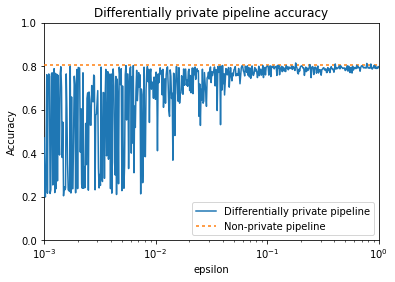

In [9]:
import matplotlib.pyplot as plt
import pickle

epsilons, baseline, pipe_accuracy = pickle.load(open("pipeline_accuracy_500.p", "rb"))

plt.semilogx(epsilons, pipe_accuracy, label="Differentially private pipeline", zorder=10)
plt.plot(epsilons, np.ones_like(epsilons) * baseline, dashes=[2,2], label="Non-private pipeline", zorder=5)
plt.title("Differentially private pipeline accuracy")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xlim(epsilons[0], epsilons[-1])
plt.legend(loc=4)
plt.show()